In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
measurements=pd.read_csv("Resources/hawaii_measurements.csv")
stations=pd.read_csv("Resources/hawaii_stations.csv")
measurements.head()
stations.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station
print(measurement)

<class 'sqlalchemy.ext.automap.measurement'>


In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
last_date

'2017-08-23'

In [15]:
last_date=dt.datetime.strptime(last_date,"%Y-%m-%d")

In [16]:
# Calculate the date 1 year ago from the last data point in the database
prev_year=last_date-dt.timedelta(days=365)
print(prev_year)

2016-08-23 00:00:00


In [17]:
# Perform a query to retrieve the data and precipitation scores
prcp_12mo=session.query(measurement.date,measurement.prcp).filter(measurement.date >= prev_year).all()
prcp_12mo

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12mo_df=pd.DataFrame(prcp_12mo,columns=["Date","Precipitation"])

# Sort the dataframe by date
prcp_12mo_df=prcp_12mo_df.sort_values("Date")
prcp_12mo_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


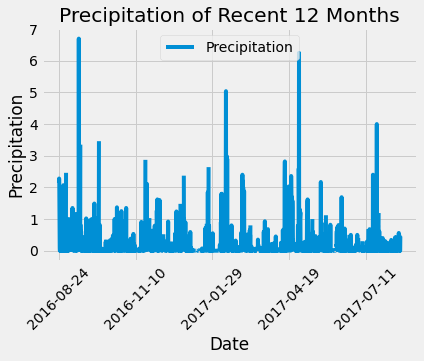

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_12mo_df.plot("Date","Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation=45)
plt.title("Precipitation of Recent 12 Months")
plt.savefig("Images/prcp_12mo.png")
plt.show()

In [20]:
#**HELP - all data or just the 12 mo data?
# Use Pandas to calcualte the summary statistics for the precipitation data
round(prcp_12mo_df.describe(),2)

,Precipitation
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [21]:
# Design a query to show how many stations are available in this dataset?
num_stations=session.query(station.id).count()
num_stations

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations=session.query(measurement.station,func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
most_active_station_stats=session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()
most_active_station_stats

(54.0, 85.0, 71.66378066378067)

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(activestations[0][0])
temp=session.query(measurement.tobs).filter(measurement.station == activestations[0][0]).filter(measurement.date >= prev_year).all()
temp_df=pd.DataFrame(temp,columns=["tobs"])
temp_df.head()

USC00519281


,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


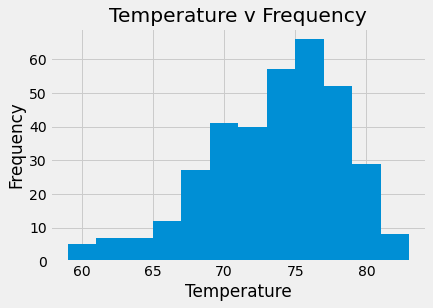

In [27]:
plt.hist(temp_df["tobs"],bins=12)
plt.title("Temperature v Frequency")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("Images/temp_histogram.png")
plt.show()

## Bonus Challenge Assignment

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
